# Classification for PSK & QAM Dataset


This notebook uses PSK and QAM families dataset for training customized EffiecientNet models. the dataset consists of 130K samples for 13 classes to be classifed, so there are 10K samples for each class

### Import Libraries

In [1]:
from torchsig.models.iq_models.efficientnet.efficientnet import efficientnet_b0
import torch
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F
import torchsig.transforms as ST
import numpy as np
import torchsig
import os
import shutil
from torch.utils.data import Subset
from sigPSK_PAM import Sig53
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from Train_evaluate import *
from torch import nn, optim

----
### Data reading

In [3]:
selected_classes = [
    "bpsk",
    "qpsk",
    "8psk",
    "16psk",
    "32psk",
    "16qam",
    "32qam",
    "32qam_cross",
    "64qam",
    "128qam_cross",
    "256qam",
    "512qam_cross",
    "1024qam"
    ]

In [ ]:
# Specify Sig53 Options
root = "../../../../data/torchsig/sigQAM&PAM/"
train = True
impaired = False
class_list = list(Sig53._idx_to_name_dict.values())
transform = ST.Compose([
    ST.RandomPhaseShift(phase_offset=(-1, 1)),
    ST.Normalize(norm=np.inf),
    ST.ComplexTo2D(),
])
target_transform = ST.DescToClassIndex(class_list=class_list)

# Instantiate the Sig53 Clean Training Dataset
sig53_clean_train = Sig53(
    root=root,
    train=train,
    impaired=impaired,
    transform=transform,
    target_transform=target_transform,
    use_signal_data=True,
)

# Instantiate the Sig53 Clean Validation Dataset
train = False
sig53_clean_val = Sig53(
    root=root,
    train=train,
    impaired=impaired,
    transform=transform,
    target_transform=target_transform,
    use_signal_data=True,
)

# Retrieve a sample and print out information to verify
idx = np.random.randint(len(sig53_clean_train))
data, label = sig53_clean_train[idx]
print("Dataset length: {}".format(len(sig53_clean_train)))
print("Data shape: {}".format(data.shape))
print("Label Index: {}".format(label))
print("Label Class: {}".format(Sig53.convert_idx_to_name(label)))

----
### Dataloaders

In [4]:
# Calculate the size of the validation set (10% of the training set)
val_size = int(0.1 * len(sig53_clean_train))
train_size = len(sig53_clean_train) - val_size

# Split the training dataset into training and validation datasets
train_dataset, val_dataset = torch.utils.data.random_split(sig53_clean_train, [train_size, val_size])

# Create data loaders for training, validation, and testing
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=16,
    num_workers=8,
    shuffle=True,
    drop_last=True,
)
val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=16,
    num_workers=8,
    shuffle=False,
    drop_last=True,
)
test_dataloader = DataLoader(
    dataset=sig53_clean_val,
    batch_size=16,
    num_workers=8,
    shuffle=False,
    drop_last=True,
)

----
### Call and Train Model
Loading the model structure to be trained

#### Efficientnet B0

In [5]:
model = efficientnet_b0(
    pretrained=False,
    path="efficientnet_b0.pt",
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

----
### Training

In [6]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

In [7]:
trainer = ModelTrainer(model, train_dataloader, val_dataloader, criterion, optimizer, device)
trainer.run_training_loop(num_epochs)

Epoch 1/10


Training: 100%|██████████| 7312/7312 [06:19<00:00, 19.29it/s, loss=0.7949, accuracy=64.29%]


Epoch 1: Train Loss 0.7949, Acc 64.29%, Val Loss 0.2271, Val Acc 90.22%
Epoch 2/10


Training: 100%|██████████| 7312/7312 [06:10<00:00, 19.72it/s, loss=0.1586, accuracy=93.43%]


Epoch 2: Train Loss 0.1585, Acc 93.43%, Val Loss 0.0491, Val Acc 98.55%
Epoch 3/10


Training: 100%|██████████| 7312/7312 [06:17<00:00, 19.37it/s, loss=0.0722, accuracy=97.42%]


Epoch 3: Train Loss 0.0722, Acc 97.42%, Val Loss 0.0180, Val Acc 99.42%
Epoch 4/10


Training: 100%|██████████| 7312/7312 [06:17<00:00, 19.36it/s, loss=0.0484, accuracy=98.39%]


Epoch 4: Train Loss 0.0484, Acc 98.39%, Val Loss 0.0229, Val Acc 99.49%
Epoch 5/10


Training: 100%|██████████| 7312/7312 [06:26<00:00, 18.92it/s, loss=0.0371, accuracy=98.83%]


Epoch 5: Train Loss 0.0371, Acc 98.83%, Val Loss 0.0034, Val Acc 99.92%
Epoch 6/10


Training: 100%|██████████| 7312/7312 [06:23<00:00, 19.07it/s, loss=0.0308, accuracy=99.04%]


Epoch 6: Train Loss 0.0308, Acc 99.04%, Val Loss 0.0021, Val Acc 99.95%
Epoch 7/10


Training: 100%|██████████| 7312/7312 [06:23<00:00, 19.06it/s, loss=0.0236, accuracy=99.25%]


Epoch 7: Train Loss 0.0236, Acc 99.25%, Val Loss 0.1322, Val Acc 97.20%
Epoch 8/10


Training: 100%|██████████| 7312/7312 [06:18<00:00, 19.31it/s, loss=0.0234, accuracy=99.28%]


Epoch 8: Train Loss 0.0234, Acc 99.28%, Val Loss 0.0019, Val Acc 99.93%
Epoch 9/10


Training: 100%|██████████| 7312/7312 [06:16<00:00, 19.44it/s, loss=0.0180, accuracy=99.40%]


Epoch 9: Train Loss 0.0180, Acc 99.40%, Val Loss 0.0303, Val Acc 99.03%
Stopping early due to no improvement in validation accuracy.
Loaded best model from best_model_checkpoint.pth


----
### Evaluation

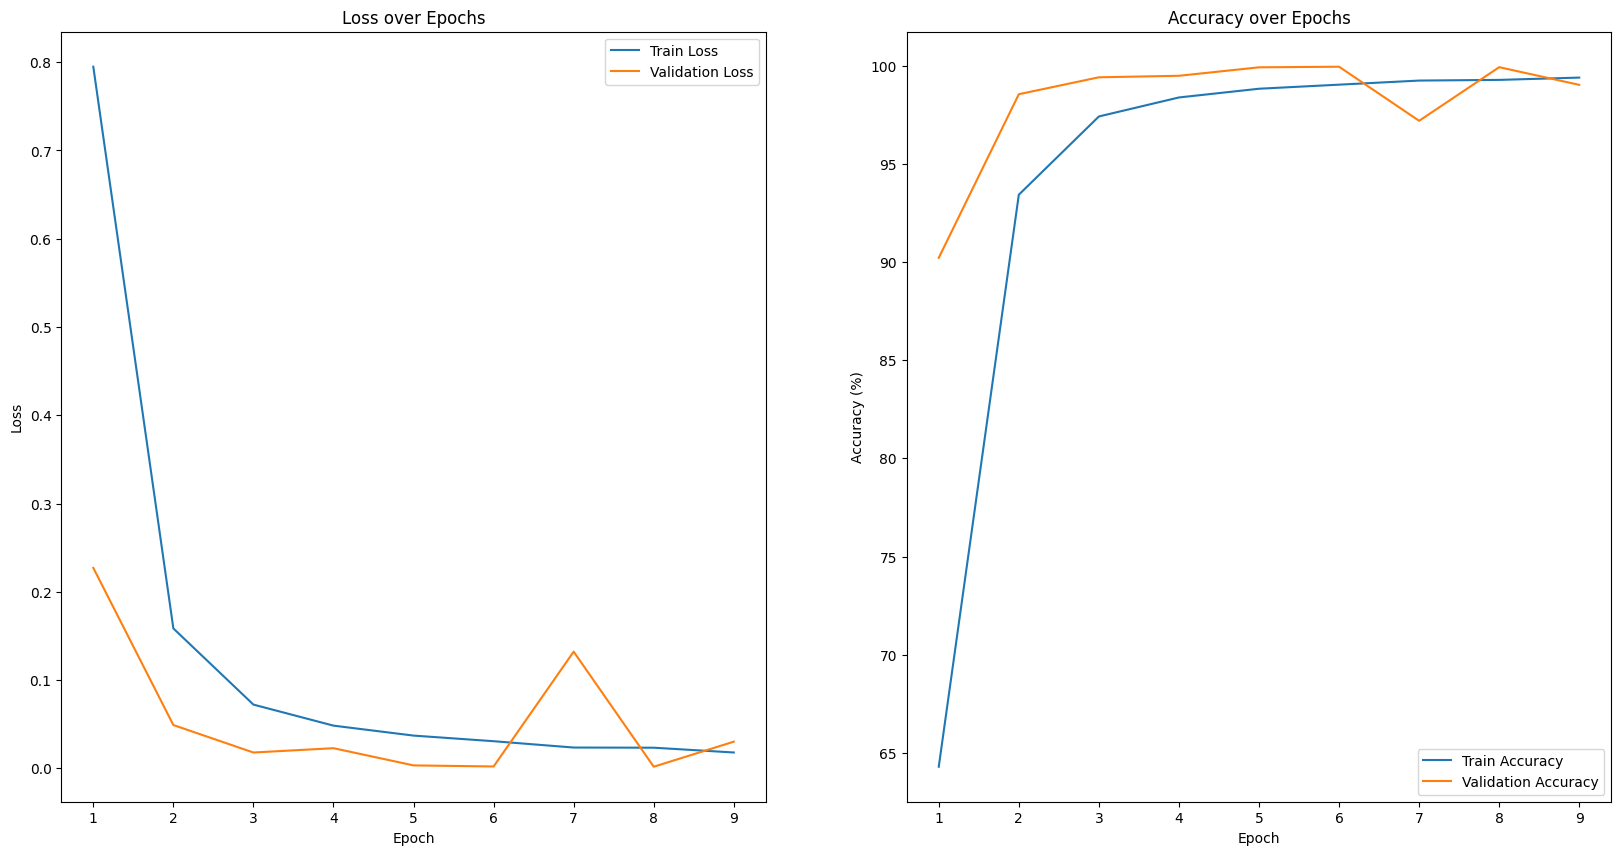

<Figure size 2000x2000 with 0 Axes>

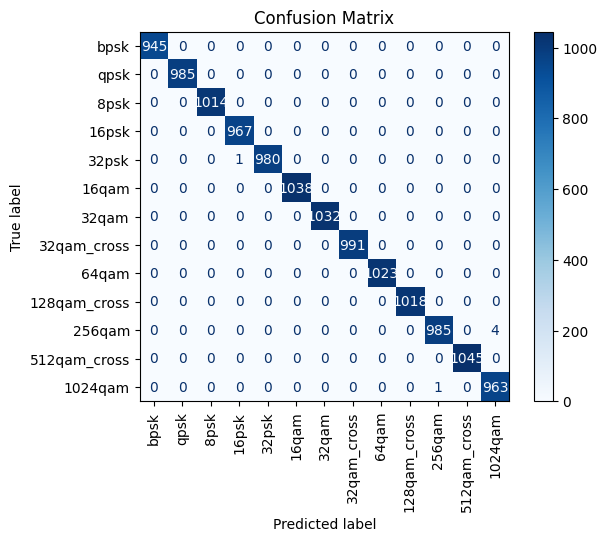

In [19]:
results = evaluate_model(trainer.model, trainer.val_dataloader, trainer.criterion, trainer.device)

labels = results['all_labels']
predictions = results['all_predictions']
plot_metrics(trainer, labels, predictions)

plot_conf_matrix( labels, predictions,selected_classes)

In [9]:

report = classification_report(labels, predictions, target_names=class_list)
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

        bpsk       1.00      1.00      1.00       945
        qpsk       1.00      1.00      1.00       985
        8psk       1.00      1.00      1.00      1014
       16psk       1.00      1.00      1.00       967
       32psk       1.00      1.00      1.00       981
       16qam       1.00      1.00      1.00      1038
       32qam       1.00      1.00      1.00      1032
 32qam_cross       1.00      1.00      1.00       991
       64qam       1.00      1.00      1.00      1023
128qam_cross       1.00      1.00      1.00      1018
      256qam       1.00      1.00      1.00       989
512qam_cross       1.00      1.00      1.00      1045
     1024qam       1.00      1.00      1.00       964

    accuracy                           1.00     12992
   macro avg       1.00      1.00      1.00     12992
weighted avg       1.00      1.00      1.00     12992



The performance is almost perfect for all classes, so it will be saved for further use

In [10]:
torch.save(trainer.model.state_dict(), './models/PSK&QAM_B0')

Model Loading

In [ ]:
# Define the model architecture
model = efficientnet_b0(pretrained=False)

# Load the model's state_dict
model_path = './models/PSK&QAM_B0'
model.load_state_dict(torch.load(model_path))


